# Delay discounting task


## 1. Initialization

### 1) Task: Delay discounting task

- **Design variables**
    - `t_ss` ($t_{SS}$): Delay for the SS (smaller, sooner) option
    - `t_ll` ($t_{LL}$): Delay for the LL (larger, later) option
        - The delay on SS option should be sooner than that of LL option ($t_{SS} < t_{LL}$).
    - `r_ss` ($R_{SS}$): Reward value for the SS (smaller, sooner) option
    - `r_ll` ($R_{LL}$): Reward value for the LL (larger, later) option
        - The reward on SS option should be smaller than that of LL option ($R_{SS} < R_{LL}$).
- **Possible responses**:
    - `choice`: `0` (SS option), `1` (LL option)

In [1]:
from adopy.tasks.dd import TaskDD
# from adopy.base._task import Task

task = TaskDD()

# 'Delay discounting task'
# task.name

# in IDM_model we have the same parameters but are named slightly different:
# ['time_null','time_reward','value_null','value_reward']
# ['t_ss','t_ll','r_ss','r_ll']
# task.designs

# ['choice']
# task.responses

### 2) Model: Hyperbolic model (Mazur, 1987)

$$
\begin{aligned}
    \text{discounting factor} \; D(t) &= \frac{1}{1 + kt} \\
    V_{SS} &= R_{SS} \cdot D(t_{SS}) \\
    V_{LL} &= R_{LL} \cdot D(t_{LL}) \\
    P(LL \, over \, SS) &= \frac{1}{1 + \exp [- \tau \cdot \gamma (V_{LL} - V_{SS})]}
\end{aligned}
$$

- **Model parameters**
    - `k` ($k$): discounting rate parameter
    - `tau` ($\tau$): inverse temperature

In [2]:
from adopy.tasks.dd import ModelHyp

# Several Models available
""" 
    'ModelExp',
    'ModelHyp',
    'ModelHPB',
    'ModelCOS',
    'ModelQH',
    'ModelDE',
"""

model = ModelHyp()

# 'Hyperbolic model for the DD task'
# model.name

# in IDM_model we have the same parameters but are named slightly different:
# ['kappa','gamma']
# ['k', 'tau']
# model.params


### 3) Grid definition

In [3]:
import numpy as np

### We will keep these grid definitions as they are. We will change after we figure out how this works ###

# in IDM_model we have the same parameters but are named slightly different:
# ['time_null','time_reward','value_null','value_reward']
# ['t_ss','t_ll','r_ss','r_ll']

grid_design = {
    # [Now]
    't_ss': [0],
    # [3 days, 5 days, 1 week, 2 weeks, 3 weeks,
    #  1 month, 6 weeks, 2 months, 10 weeks, 3 months,
    #  4 months, 5 months, 6 months, 1 year, 2 years,
    #  3 years, 5 years, 10 years] in a weekly unit
    't_ll': [0.43, 0.714, 1, 2, 3,
             4.3, 6.44, 8.6, 10.8, 12.9,
             17.2, 21.5, 26, 52, 104,
             156, 260, 520],
    # [$12.5, $25, ..., $775, $787.5]
    'r_ss': np.arange(12.5, 800, 12.5),
    # [$800]
    'r_ll': [800]
}

# in IDM_model we have the same parameters but are named slightly different:
# ['kappa','gamma']
# ['k','tau']

grid_param = {
    # 50 points on [10^-5, ..., 1] in a log scale
    'k': np.logspace(-5, 0, 50, base=10),
    # 10 points on (0, 5] in a linear scale
    'tau': np.linspace(0, 5, 11)[1:]
}

grid_response = {
    'choice': [0, 1]
}

### 4) Engine initialization

In [4]:
from adopy import Engine

engine = Engine(task, model, grid_design, grid_param, grid_response)

# Posterior means (k, tau)
# [k,tau] = [0.120679,1.879091]
# engine.post_mean

# Standard deviations for the posterior distribution (k, tau)
# [k,tau] = [0.210282,1.436140]
# engine.post_sd


## 2. Using ADO

### Initializing  parameters for simulation


In [11]:
# number of trials
N_TRIAL = 20

# 1 week, 2 weeks, 1 month, 6 months, 1 year, 2 years, 10 years
D_CAND = [1, 2, 4.3, 26, 52, 104, 520]

# DELTA_R_SS for the staircase method:
# The amount of changes on R_SS every 6 trials.
DELTA_R_SS = [400, 200, 100, 50, 25, 12.5]

# True parameter values to simulate responses
# after we get this to work, we can select from prior distribution
PARAM_TRUE = {'k': 0.12, 'tau': 1.5}

### Generate choice/response using the true parameters

In [6]:
from scipy.stats import bernoulli

def get_simulated_response(design):
    # Calculate the probability to choose a variable option
    t_ss, t_ll, r_ss, r_ll = (
        design['t_ss'], design['t_ll'],
        design['r_ss'], design['r_ll']
    )
    k, tau = PARAM_TRUE['k'], PARAM_TRUE['tau']
    
    u_ss = r_ss * (1. / (1 + k * t_ss))
    u_ll = r_ll * (1. / (1 + k * t_ll))
    p_obs = 1. / (1 + np.exp(-tau * (u_ll - u_ss)))

    # Randomly sample a binary choice response from Bernoulli distribution
    return bernoulli.rvs(p_obs)



In [7]:

def ask_for_response(design):
    response = input('Please choose: >>>(0) {} in {} days<<< OR >>>(1) {} in {} days<<<'.format(design['r_ss'],design['t_ss'],design['r_ll'],design['t_ll']))
    response = int(response)
    if response in [0,1]:
        pass
    else:
        print('ERROR, you selected {}, response needs to be 0 or 1'.format(response))
        print('Exiting now, try again')
        exit
    return response


### Simulation

In [8]:
import pandas as pd

# Make an empty DataFrame to store data
columns = ['trial', 'response', 'mean_k', 'mean_tau', 'sd_k', 'sd_tau','t_ss','t_ll','r_ss','r_ll']
df_simul = pd.DataFrame(None, columns=columns)

# Reset the engine as an initial state
engine.reset()

for i in range(N_TRIAL):
    # Design selection / optimization
    design = engine.get_design('optimal')
    # print(design)
    
    # Experiment
    response = ask_for_response(design)
    
    # Bayesian updating
    engine.update(design, response)

    # Save the information for updated posteriors
    dict_app = {
        'trial': i + 1,
        'response': response,
        'mean_k': engine.post_mean[0],
        'mean_tau': engine.post_mean[1],
        'sd_k': engine.post_sd[0],
        'sd_tau': engine.post_sd[1],
    }
    dict_app.update(design)
    df_app = pd.DataFrame(dict_app,index=[0])
    df_simul = pd.concat([df_simul,df_app],ignore_index=True)

print(df_simul[task.designs])


   t_ss        t_ll   r_ss   r_ll
0   0.0  260.000000  437.5  800.0
1   0.0   21.500000  375.0  800.0
2   0.0   52.000000  475.0  800.0
3   0.0   26.000000  475.0  800.0
4   0.0   17.200001  462.5  800.0


In [14]:
import pandas as pd
import os,sys

# Make an empty DataFrame to store data
columns = ['trial', 'response', 'mean_k', 'mean_tau', 'sd_k', 'sd_tau','t_ss','t_ll','r_ss','r_ll']
df_simul = pd.DataFrame(None, columns=columns)


# Reset the engine as an initial state
engine.reset()

for i in range(N_TRIAL):
    # Design selection / optimization
    design = engine.get_design('optimal')
    # print(design)
    
    # Experiment
    response = get_simulated_response(design)
    
    # Bayesian updating
    engine.update(design, response)

    # Save the information for updated posteriors
    dict_app = {
        'trial': i + 1,
        'response': response,
        'mean_k': engine.post_mean[0],
        'mean_tau': engine.post_mean[1],
        'sd_k': engine.post_sd[0],
        'sd_tau': engine.post_sd[1],
    }
    dict_app.update(design)
    df_app = pd.DataFrame(dict_app,index=[0])
    df_simul = pd.concat([df_simul,df_app],ignore_index=True)

print(df_simul[task.designs])

    t_ss     t_ll   r_ss   r_ll
0    0.0  260.000  437.5  800.0
1    0.0   21.500  375.0  800.0
2    0.0    4.300  412.5  800.0
3    0.0   12.900  337.5  800.0
4    0.0    6.440  425.0  800.0
5    0.0    1.000  712.5  800.0
6    0.0    1.000  712.5  800.0
7    0.0    0.714  737.5  800.0
8    0.0    0.714  737.5  800.0
9    0.0    0.714  737.5  800.0
10   0.0    0.714  737.5  800.0
11   0.0    0.714  737.5  800.0
12   0.0    0.714  737.5  800.0
13   0.0    0.714  737.5  800.0
14   0.0    0.714  737.5  800.0
15   0.0    0.714  737.5  800.0
16   0.0    0.714  737.5  800.0
17   0.0    4.300  525.0  800.0
18   0.0    1.000  712.5  800.0
19   0.0    1.000  712.5  800.0


In [15]:
print(df_simul)

   trial response    mean_k  mean_tau          sd_k    sd_tau  t_ss     t_ll  \
0      1        0  0.190489  2.750000  2.653216e-01  1.436140   0.0  260.000   
1      2        0  0.350037  2.750001  2.866642e-01  1.436141   0.0   21.500   
2      3        1  0.116145  2.750000  4.573661e-02  1.436141   0.0    4.300   
3      4        0  0.155464  2.749996  2.962155e-02  1.436142   0.0   12.900   
4      5        1  0.120679  2.749991  7.098342e-05  1.436145   0.0    6.440   
5      6        1  0.120679  2.890611  4.997383e-05  1.392493   0.0    1.000   
6      7        1  0.120679  3.010644  5.171951e-05  1.347268   0.0    1.000   
7      8        0  0.120679  3.148996  2.618349e-06  1.298122   0.0    0.714   
8      9        0  0.120679  3.267769  1.555802e-07  1.249251   0.0    0.714   
9     10        0  0.120679  3.369709  1.302663e-08  1.202687   0.0    0.714   
10    11        0  0.120679  3.457520  9.448887e-09  1.159458   0.0    0.714   
11    12        0  0.120679  3.533639  9

In [18]:


last_trial = df_simul.iloc[-1]

print(last_trial)


trial             20
response           1
mean_k      0.120679
mean_tau    2.071846
sd_k             0.0
sd_tau      0.819137
t_ss             0.0
t_ll             1.0
r_ss           712.5
r_ll           800.0
Name: 19, dtype: object


In [20]:

# SV_delta = SV_delay - SV_now
SV_delta = 10

'''
pick immed reward first, then choose 

focus on one parameter value reward to get 
SV_difference = +/- 5,10,15
keep unbounded
reasonable indifference points

extreme cases will be more challenging

'''




'''

# SV = v / 1+kappa*delay

SV_now = 712.5 / 1+(0.120679)*0 
SV_now = 712.5

SV_later = SV_now+10 = 722.5

722.5 = r_ll / 1+(0.120679)*1.0
r_ll = 722*(1.120679) = 809.13


'''

# print(722*1.120679)


809.130238


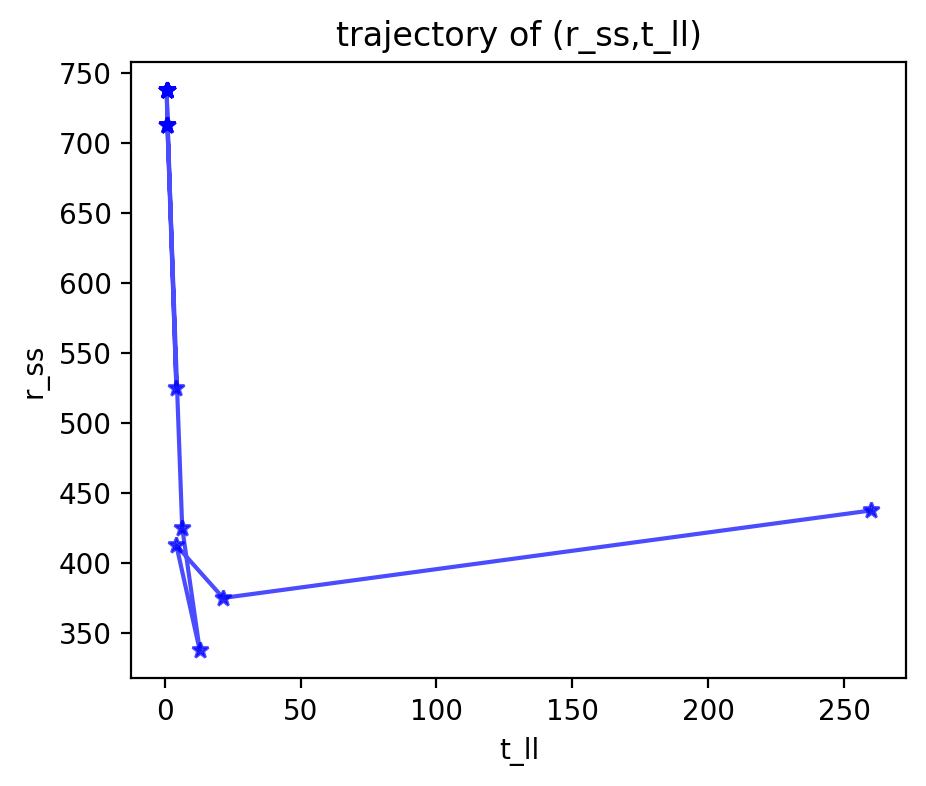

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize = [5, 4])

# Draw black dotted lines for true parameters

df_cond = df_simul
line_color = 'blue'
ax = df_cond.plot(x='t_ll', y='r_ss', ax=ax,style='*-',
                    subplots=True, legend=False, color = line_color, alpha = 0.7)
ax[0].set_ylabel('r_ss')
# Set titles and limits on y axes.
ax[0].set_title('trajectory of (r_ss,t_ll)')

plt.show()

### Results

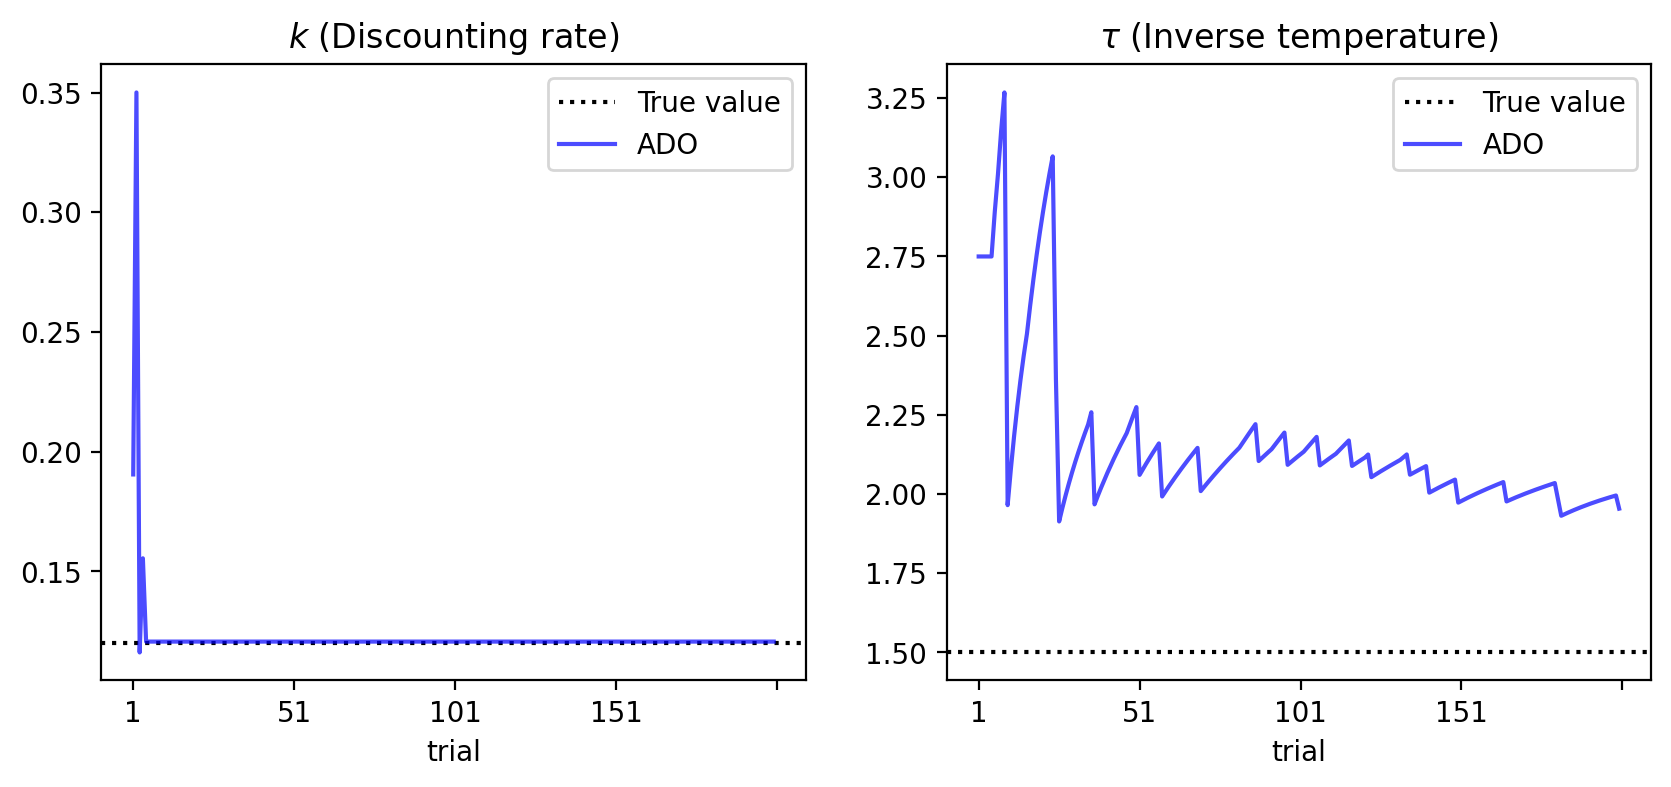

In [97]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize = [10, 4])

# Draw black dotted lines for true parameters
for i, param in enumerate(['k', 'tau']):
    ax[i].axhline(PARAM_TRUE[param], color='black', linestyle=':')

df_cond = df_simul
line_color = 'blue'
ax = df_cond.plot(x='trial', y=['mean_k', 'mean_tau'], ax=ax,
                    subplots=True, legend=False, color = line_color, alpha = 0.7)

# Set titles and limits on y axes.
ax[0].set_title('$k$ (Discounting rate)')
ax[1].set_title('$\\tau$ (Inverse temperature)')

ax[0].legend(['True value', 'ADO'])
ax[1].legend(['True value', 'ADO'])
    
plt.show()

## References

Green, L. & Myerson, J. (2004). A discounting framework for choice with delayed and probabilistic rewards. Psychological Bulletin, 130, 769–792.

Mazur, J. E. (1987). An adjusting procedure for studying delayed reinforcement. Commons, ML.; Mazur, JE.; Nevin, JA, 55–73.
